In [1]:
import sys
sys.path.append("../../")
from mfmodeling import NARGP, SingleGP
import pickle

# Uncomment below to use GPy implementation.
# Note that only RBF kernel is supported in the GPy implementation now.
"""
from mfmodeling.SingleGP_GPy import SingleGP
from mfmodeling import set_gpy_usage_in_nargp
set_gpy_usage_in_nargp(True)
"""

help(NARGP)

2024-10-23 12:16:08.944143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 12:16:09.026129: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 12:16:09.030111: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/

Help on class NARGP in module mfmodeling.NARGP:

class NARGP(builtins.object)
 |  NARGP(*args, **kwargs)
 |  
 |  Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP).
 |  P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
 |  Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Parameters
 |      ----------
 |      data_list : list[nfidelity]
 |          List of multi-fidelity training data of y=f(x), where input x and output y are vectors.
 |      
 |          Structure of the list of data is as follow.
 |          data_list[ 0] = [data_input_lowest[nsample_lowest,ninput],   data_output_lowest[nsample_lowest,noutput_lowest]]
 |          data_list[ 1] = [data_input_1st[nsample_1st,ninput],         data_output_1st[nsample_1st,noutput_1st]]
 |          ...
 |          data_list[-1] = [data_input_highest[

### Preparation of data set

In [2]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

np.random.seed(11)
tf.random.set_seed(11)

def high(x):
    '''
    Exact Branin function f_3
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    return (-1.275*x1**2 / np.pi**2 + 5.0*x1/np.pi + x2 - 6.0)**2 + (10.0 - 5.0/(4.0*np.pi))*np.cos(x1) + 10.0

def medium(x):
    '''
    Medium-fidelity function f_2
    P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
    Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    return 10.0*np.sqrt(high(x-2.0)) + 2.0*(x1-0.5)-3.0*(3.0*x2-1.0) - 1.0

def low(x):
    '''
    Low-fidelity function f_2
    P. Perdikaris, et al., "Nonlinear information fusion algorithms for data-efficient multi-fidelity modeling"
    Proc. R. Soc. A 473, 20160751 (2017). http://dx.doi.org/10.1098/rspa.2016.0751
    '''
    x1 = x[...,0]
    x2 = x[...,1]
    return medium(1.2*(x+2.0)) - 3.0*x2 + 1.0

def scale_range(x,ub,lb):
    Np = x.shape[0]
    dim = x.shape[1]
    for i in range(0,Np):
        for j in range(0,dim):
            tmp = ub[j] -lb[j]
            x[i][j] = tmp*x[i][j] + lb[j]
    return x

def rmse(pred, truth):
    pred = pred.flatten()
    truth = truth.flatten()
    return np.sqrt(np.mean((pred-truth)**2))


nlow = 80
w0 = -5 + 15*np.random.rand(nlow)
w1 = 15 * np.random.rand(nlow)
data_low_x = np.stack([w0,w1],axis=-1)
data_low_y = low(data_low_x)

nmed = 40
perm = np.random.permutation(nlow)
data_med_x = data_low_x[perm[0:nmed],:]

# data_restrict = data_med_x[data_med_x[:,0]<5]
data_restrict = data_med_x[data_med_x[:,1]<10]
nhigh = 20
if data_restrict.shape[0] < nhigh:
    print("Data points in the restricted region is too small")
else:
    perm = np.random.permutation(data_restrict.shape[0])
    data_high_x = data_restrict[perm[0:nhigh],:]

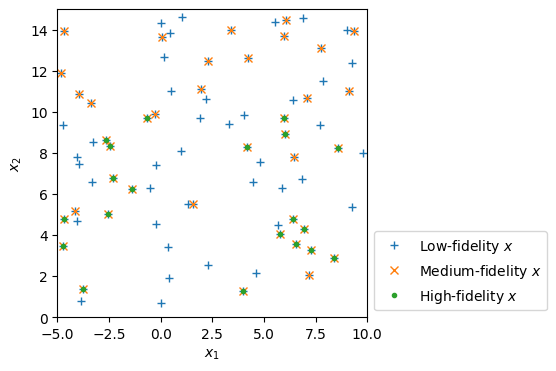

In [3]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.plot(data_low_x[:,0],data_low_x[:,1],"+",label=r"Low-fidelity $x$")
ax.plot(data_med_x[:,0],data_med_x[:,1],"x",label=r"Medium-fidelity $x$")
ax.plot(data_high_x[:,0],data_high_x[:,1],".",label=r"High-fidelity $x$")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_xlim(-5,10)
ax.set_ylim(0,15)
ax.legend(loc="lower left", bbox_to_anchor=(1,0))
plt.show()

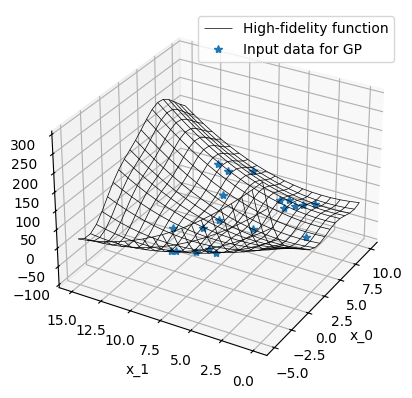

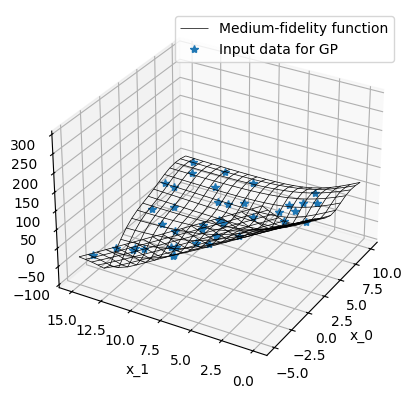

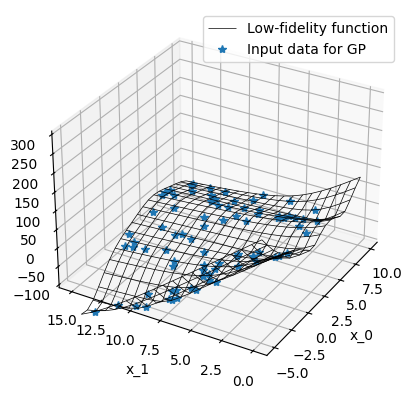

In [4]:
# 推定に用いる入力データ: Low, medium, high-fidelity dataset
data_low_y = low(data_low_x)
data_med_y = medium(data_med_x)
data_high_y = high(data_high_x)

# データセットの描画
%matplotlib inline
# %matplotlib qt
x0 = np.linspace(-5,10,20)
x1 = np.linspace(0,15,20)
x0m, x1m = np.meshgrid(x0,x1)
xm = np.stack([x0m,x1m],axis=-1)

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(x0m,x1m,high(xm),lw=0.5,color="black",label="High-fidelity function")
ax.plot(data_high_x[:,0],data_high_x[:,1],data_high_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-100,300)
ax.view_init(30,-150)
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(x0m,x1m,medium(xm),lw=0.5,color="black",label="Medium-fidelity function")
ax.plot(data_med_x[:,0],data_med_x[:,1],data_med_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-100,300)
ax.view_init(30,-150)
ax.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot_wireframe(x0m,x1m,low(xm),lw=0.5,color="black",label="Low-fidelity function")
ax.plot(data_low_x[:,0],data_low_x[:,1],data_low_y,"*",label="Input data for GP")
ax.set_xlabel(r"x_0")
ax.set_ylabel(r"x_1")
ax.set_zlim(-100,300)
ax.view_init(30,-150)
ax.legend()
plt.show()

### Nonlinear autoregressive multi-fidelity Gaussian process regression (NARGP)

In [5]:
# Set kernel name to use
# KERNEL_NAME = "RBF"
# KERNEL_NAME = "SpectralMixture"
KERNEL_NAME = "NeuralKernelNetwork"

data_list = [[data_low_x,data_low_y[:,None]],
             [data_med_x,data_med_y[:,None]],
             [data_high_x,data_high_y[:,None]]]
single_gp_config_list = [
    {"kernel": KERNEL_NAME},
    {"kernel": KERNEL_NAME},
    {"kernel": KERNEL_NAME},
]

# Uncomment the following to use different kernel for different fidelity data.
# However, if GPy implementation are being used,
# Spectral Mixture Kernel and Neural Kernel Network are not implemented,
# so RBF will be used.

# Different kernel for each fidelity
#single_gp_config_list = [
#    {"kernel": "RBF"},
#    {"kernel": "SpectralMixture"},
#    {"kernel": "NeuralKernelNetwork"},
#]

# Different initialization for each fidelity
#single_gp_config_list = [
#    {"kernel": "RBF", "kernel_args": {"lengthscales": [1.0, 1.0]}},
#    {"kernel": "RBF", "kernel_args": {"lengthscales": [2.0, 2.0]}},
#    {"kernel": "RBF", "kernel_args": {"lengthscales": [3.0, 3.0]}},
#]

model_nargp = NARGP(
    data_list = data_list,
    single_gp_config_list=single_gp_config_list,
    normalize=True)
from time import time as timer
t1=timer()
model_nargp.optimize(optimize_restarts=10, nMonteCarlo=1000, verbose=True)
t2=timer(); print(t2-t1, xm.size)


if KERNEL_NAME == "RBF":
    with open("model_NARGP_RBF.pkl","wb") as f:
        pickle.dump(model_nargp,f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_NARGP_SMK.pkl","wb") as f:
        pickle.dump(model_nargp,f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_NARGP_NKN.pkl","wb") as f:
        pickle.dump(model_nargp,f)


if KERNEL_NAME == "RBF":
    with open("model_NARGP_RBF.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_NARGP_SMK.pkl","rb") as f:
        model_nargp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_NARGP_NKN.pkl","rb") as f:
        model_nargp = pickle.load(f)



t1=timer()
mean, var = model_nargp.predict(xm.reshape(xm.size//2,2),nMonteCarlo=100)
t2=timer(); print(t2-t1, xm.size)

NARGP is using GPflow.
nfidelity= 3 , optimize_restarts= 10 , max_iters= 400
optimize_restarts= 10 , max_iters= 400


2024-10-23 12:16:11.835019: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.12/opt/mpi/libfabric/lib:/opt/intel/oneapi/mpi/2021.12/lib:/opt/intel/oneapi/mkl/2024.1/lib:/opt/intel/oneapi/ippcp/2021.11/lib/:/opt/intel/oneapi/ipp/2021.11/lib:/opt/intel/oneapi/dpl/2022.5/lib:/opt/intel/oneapi/dnnl/2024.1/lib:/opt/intel/oneapi/debugger/2024.1/opt/debugger/lib:/opt/intel/oneapi/dal/2024.2/lib:/opt/intel/oneapi/compiler/2024.1/opt/oclfpga/host/linux64/lib:/opt/intel/oneapi/compiler/2024.1/opt/compiler/lib:/opt/intel/oneapi/compiler/2024.1/lib:/opt/intel/oneapi/ccl/2021.12/lib/
2024-10-23 12:16:11.835106: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
202

Optimization restart 1/10,  f =  -106.4946563074224


Optimization restart 2/10,  f =  -104.98525268100668


Optimization restart 3/10,  f =  -105.49994853093581


Optimization restart 4/10,  f =  -99.32227789921032


Optimization restart 5/10,  f =  -108.96054972152103


Optimization restart 6/10,  f =  -105.6653607623293


Optimization restart 7/10,  f =  -107.47569058950575


Optimization restart 8/10,  f =  -109.98108406137708


Optimization restart 9/10,  f =  -106.8840797936217


Optimization restart 10/10,  f =  -107.46006907817471


optimize_restarts= 10 , max_iters= 400
Optimization restart 1/10,  f =  -39.17960519776112


Optimization restart 2/10,  f =  -40.55625242500831


Optimization restart 3/10,  f =  -40.55603530825677


Optimization restart 4/10,  f =  -39.74836740570173


Optimization restart 5/10,  f =  -42.19760695917944


Optimization restart 6/10,  f =  -40.01337363620407


Optimization restart 7/10,  f =  -43.2906956734581


Optimization restart 8/10,  f =  -0.37696151071842365


Optimization restart 9/10,  f =  -39.292531965894455


Optimization restart 10/10,  f =  -40.21953173671672


optimize_restarts= 10 , max_iters= 400
Optimization restart 1/10,  f =  -17.285398283288536


Optimization restart 2/10,  f =  -18.825689180535093


Optimization restart 3/10,  f =  -18.9521275179063


Optimization restart 4/10,  f =  -9.106006967800152


Optimization restart 5/10,  f =  -11.332060403424023


Optimization restart 6/10,  f =  -11.327289965360567


Optimization restart 7/10,  f =  -18.7629342851608


Optimization restart 8/10,  f =  28.378772516181396


Optimization restart 9/10,  f =  -18.812496323226924


Optimization restart 10/10,  f =  20.640792323210796


160.33739733695984 800
38.843616008758545 800


### Single GP using only high-fidelity data (for comparison)

In [6]:
data = [data_high_x,data_high_y[:,None]]
model_singlegp = SingleGP(data = data, kernel=KERNEL_NAME, normalize=True)
model_singlegp.optimize(optimize_restarts=10, verbose=True)


if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","wb") as f:
        pickle.dump(model_singlegp,f)


if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","rb") as f:
        model_singlegp = pickle.load(f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","rb") as f:
        model_singlegp = pickle.load(f)


mean_singlegp, var_singlegp = model_singlegp.predict(xm.reshape(xm.size//2,2))

optimize_restarts= 10 , max_iters= 400
Optimization restart 1/10,  f =  -6.166939412754218


Optimization restart 2/10,  f =  -4.7022357755209505


Optimization restart 3/10,  f =  -13.29068075589463


Optimization restart 4/10,  f =  21.71646373156058


Optimization restart 5/10,  f =  -19.13593313480313


Optimization restart 6/10,  f =  7.242157769813495


Optimization restart 7/10,  f =  25.367651522023657


Optimization restart 8/10,  f =  -8.156678365423634


Optimization restart 9/10,  f =  -5.142792533580863


Optimization restart 10/10,  f =  -16.207611341287695


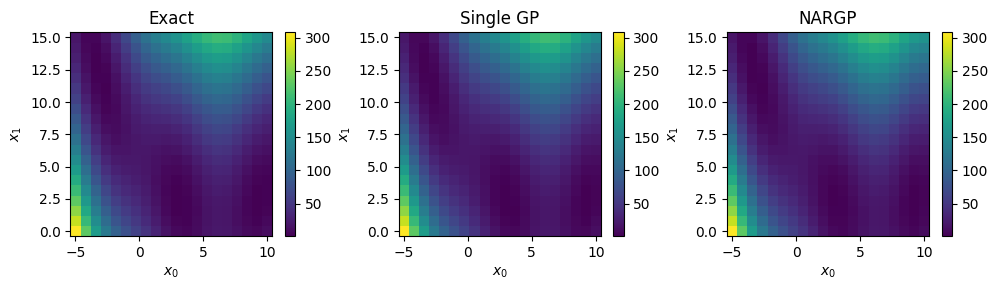

In [7]:
vmax = high(xm).max()
vmin = high(xm).min()
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
quad = ax.pcolormesh(x0m,x1m,high(xm),vmax=vmax,vmin=vmin)
ax.set_title("Exact")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(132)
quad = ax.pcolormesh(x0m,x1m,mean_singlegp.reshape(x0m.shape),vmax=vmax,vmin=vmin)
ax.set_title("Single GP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(133)
quad = ax.pcolormesh(x0m,x1m,mean.reshape(x0m.shape),vmax=vmax,vmin=vmin)
ax.set_title("NARGP")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

2.4278400868062455 1.4322709093806907 10.63709280940563 1.2157039758646135 10.63709280940563


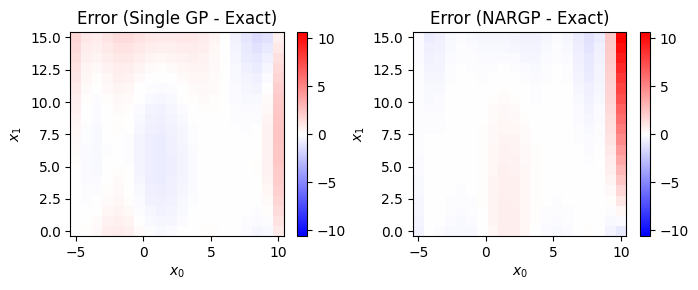

In [8]:
error_singlegp = mean_singlegp.reshape(x0m.shape)-high(xm)
error_nargp = mean.reshape(x0m.shape)-high(xm)
emax = max([error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min()])
print(error_singlegp.max(),-error_singlegp.min(),error_nargp.max(),-error_nargp.min(),emax)

fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
quad = ax.pcolormesh(x0m,x1m,error_singlegp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (Single GP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
ax = fig.add_subplot(122)
quad = ax.pcolormesh(x0m,x1m,error_nargp,vmax=emax,vmin=-emax,cmap="bwr")
ax.set_title("Error (NARGP - Exact)")
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$x_1$")
fig.colorbar(quad)
fig.tight_layout()
plt.show()

In [9]:
nsample = 1000
w0 = -5 + 15*np.random.rand(nsample)
w1 = 15 * np.random.rand(nsample)
xsample = np.stack([w0,w1],axis=-1)

t1=timer()
mean0, var0 = model_nargp.predict(xsample,ifidelity=0,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()
mean1, var1 = model_nargp.predict(xsample,ifidelity=1,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()
mean2, var2 = model_nargp.predict(xsample,ifidelity=2,nMonteCarlo=100)
t2=timer(); print(t2-t1, xsample.size); t1 = timer()

0.4626576900482178 2000
2.5880086421966553 2000
89.36886930465698 2000


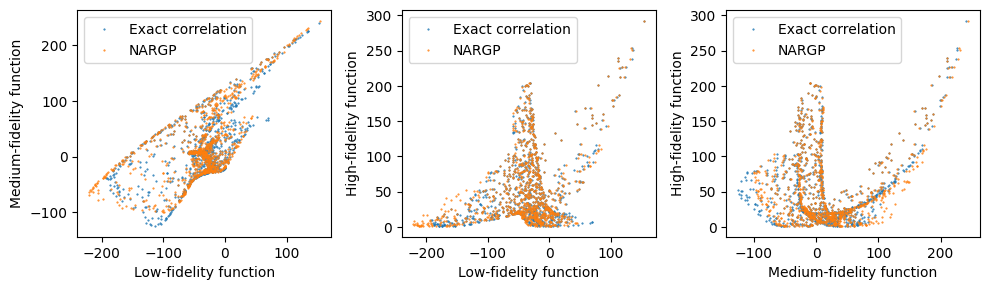

In [10]:
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(131)
ax.plot(low(xsample),medium(xsample),".",markersize=1,label="Exact correlation")
ax.plot(mean0,mean1,".",markersize=1,label="NARGP")
ax.set_xlabel("Low-fidelity function")
ax.set_ylabel("Medium-fidelity function")
ax.legend()
ax = fig.add_subplot(132)
ax.plot(low(xsample),high(xsample),".",markersize=1,label="Exact correlation")
ax.plot(mean0,mean2,".",markersize=1,label="NARGP")
ax.set_xlabel("Low-fidelity function")
ax.set_ylabel("High-fidelity function")
ax.legend()
ax = fig.add_subplot(133)
ax.plot(medium(xsample),high(xsample),".",markersize=1,label="Exact correlation")
ax.plot(mean1,mean2,".",markersize=1,label="NARGP")
ax.set_xlabel("Medium-fidelity function")
ax.set_ylabel("High-fidelity function")
fig.tight_layout()
ax.legend()
plt.show()

(1000, 1) (1000, 1)


/tmp/ipykernel_5381/4000118320.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R2_singlegp = float(1.0 - sum((exact_high-mean_singlegp)**2)/sum((exact_high-exact_high.mean())**2))
/tmp/ipykernel_5381/4000118320.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R2_nargp = float(1.0 - sum((exact_high-mean2)**2)/sum((exact_high-exact_high.mean())**2))


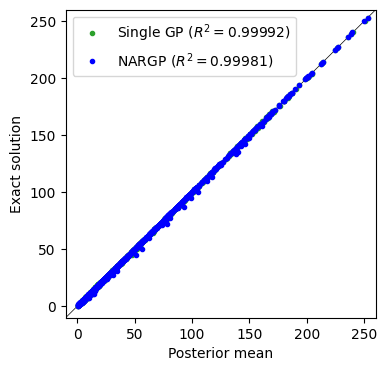

In [11]:
mean_singlegp, var_singlegp = model_singlegp.predict(xsample)
exact_high = high(xsample)[:,None]
print(exact_high.shape,mean_singlegp.shape)
R2_singlegp = float(1.0 - sum((exact_high-mean_singlegp)**2)/sum((exact_high-exact_high.mean())**2))
R2_nargp = float(1.0 - sum((exact_high-mean2)**2)/sum((exact_high-exact_high.mean())**2))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
vmin = -10
vmax = 260
ax.plot(np.linspace(vmin,vmax,2),np.linspace(vmin,vmax,2),c="k",lw=0.5)
ax.plot(mean_singlegp,exact_high,".",c="tab:green",label="Single GP ($R^2=${:.5f})".format(R2_singlegp))
ax.plot(mean2,exact_high,".",c="b",label="NARGP ($R^2=${:.5f})".format(R2_nargp))
ax.set_xlabel("Posterior mean")
ax.set_ylabel("Exact solution")
ax.set_xlim(vmin,vmax)
ax.set_ylim(vmin,vmax)
ax.legend()
plt.show()
